## Load images

In [63]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os

def imshow(img):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img).convert("RGB"))
    
def imshow_on_axis(img, ax, title):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

            
def load_images(number):
    final_images = []
    web_images = []
    ai_images = []

    final_path = f'data/final_submissions/{number}/'
    web_path = 'data/web/'
    ai_path = 'data/ai/'

  
    if not os.path.exists(final_path):
        print(f"The final submissions path '{final_path}' does not exist.")
        return None, None, None  


    for filename in os.listdir(final_path):
        img = cv2.imread(os.path.join(final_path, filename))
        if img is not None:
            final_images.append(img)

    if not final_images:
        print(f"No images found in '{final_path}'. Please check the contents.")
        return None, None, None

    for filename in os.listdir(web_path):
        if filename.startswith(str(number)):
            img = cv2.imread(os.path.join(web_path, filename))
            if img is not None:
                web_images.append(img)

    for filename in os.listdir(ai_path):
        if filename.startswith(str(number)):
            img = cv2.imread(os.path.join(ai_path, filename))
            if img is not None:
                ai_images.append(img)
    
    if not web_images and not ai_images:
        print(f"The number '{number}' does not correspond to any valid images in 'web' or 'ai' folders.")
        return None, None, None

    if not web_images:
        print(f"No web images found with prefix '{number}' in '{web_path}'.")
        return None, None, None
    if not ai_images:
        print(f"No AI images found with prefix '{number}' in '{ai_path}'.")
        return None, None, None

    return final_images, web_images, ai_images
        

## Color Histogram Indexing

In [64]:
bucket_size=256

def get_histogram(image, num_buckets=bucket_size):
    image_hsv=cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image_hsv], [0], None, [num_buckets], [0, 180]) 

    # Normalize the histogram
    hist = hist / np.sum(hist) 
    
    return hist


def hue_to_rgb(hue):
    # Create an HSV color with the given hue, full saturation, and full value (brightness)
    hsv_color = np.uint8([[[hue, 255, 255]]])  # Hue range is [0, 180] in OpenCV
    # Convert to RGB
    rgb_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2RGB)[0][0]
    return tuple(rgb_color / 255.0)  # Normalize to range [0, 1] for matplotlib

def plot_hue_histogram(hist, axes, row, col, bucket_size=bucket_size, plt_title='Hue Histogram'): 
    axes[row, col].clear()  # Clear the axis for fresh plotting
    axes[row, col].set_title(plt_title)
    axes[row, col].set_xlabel('Bins')
    axes[row, col].set_ylabel('Frequency')

    bin_width = 180 / bucket_size
    for i in range(bucket_size):
        avg_hue = i * bin_width + bin_width / 2
        color = hue_to_rgb(avg_hue)
        axes[row, col].bar(i, hist[i][0], color=color, width=1)

    axes[row, col].set_xlim([0, bucket_size - 1])
    axes[row, col].grid(axis='y', linestyle='--')



#### Histogram analysis for a given group

In [65]:
def compare_colors(group_id, bucket_size):
    
    final_images, web_images, ai_images = load_images(group_id)
    
    final_hists = [get_histogram(image, bucket_size) for image in final_images]
    web_hists = [get_histogram(image, bucket_size) for image in web_images]
    ai_hists = [get_histogram(image, bucket_size) for image in ai_images]
    
    for i in range(len(final_hists)):
        #Consider different distance metrics
        dist_web = [[cv2.compareHist(final_hists[i], web_hists[j], cv2.HISTCMP_CHISQR), web_hists[j], web_images[j]]  for j in range(len(web_hists))] 
        dist_ai = [[cv2.compareHist(final_hists[i], ai_hists[j], cv2.HISTCMP_CHISQR), ai_hists[j], ai_images[j]]  for j in range(len(ai_hists))]
    
        dist_web.sort(key=lambda x: x[0])
        dist_ai.sort(key=lambda x: x[0])
        
        fig, axes = plt.subplots(3, 6, figsize=(24, 12))
        final_image = final_images[i]
        
        imshow_on_axis(final_image, axes[0, 0], 'Final Image')
        
        plot_hue_histogram(final_hists[i], axes, 0, 1, bucket_size=bucket_size, plt_title="Histogram of Final Image")
        
        for j in range(2, 6):
            axes[0, j].axis('off')
            
        top_web_matches=dist_web[:3]
        top_ai_matches=dist_ai[:3]
        
        for j in range(3):
            similarity, hist, img = top_web_matches[j]
            
            imshow_on_axis(img, axes[1, j*2], f'Web Match {j + 1}\nSimilarity: {similarity:.4f}')
            
            plot_hue_histogram(hist, axes, 1, j*2 + 1, bucket_size=bucket_size, plt_title=f'Histogram of Web Match {j + 1}')
            
            
        for j in range(3):
            similarity, hist, img = top_ai_matches[j]
            
            imshow_on_axis(img, axes[2, j*2], f'AI Match {j + 1}\nSimilarity: {similarity:.4f}')
            
            plot_hue_histogram(hist, axes, 2, j*2 + 1, bucket_size=bucket_size, plt_title=f'Histogram of AI Match {j + 1}')
            

        plt.tight_layout()
        plt.show()

## Analysis of the result

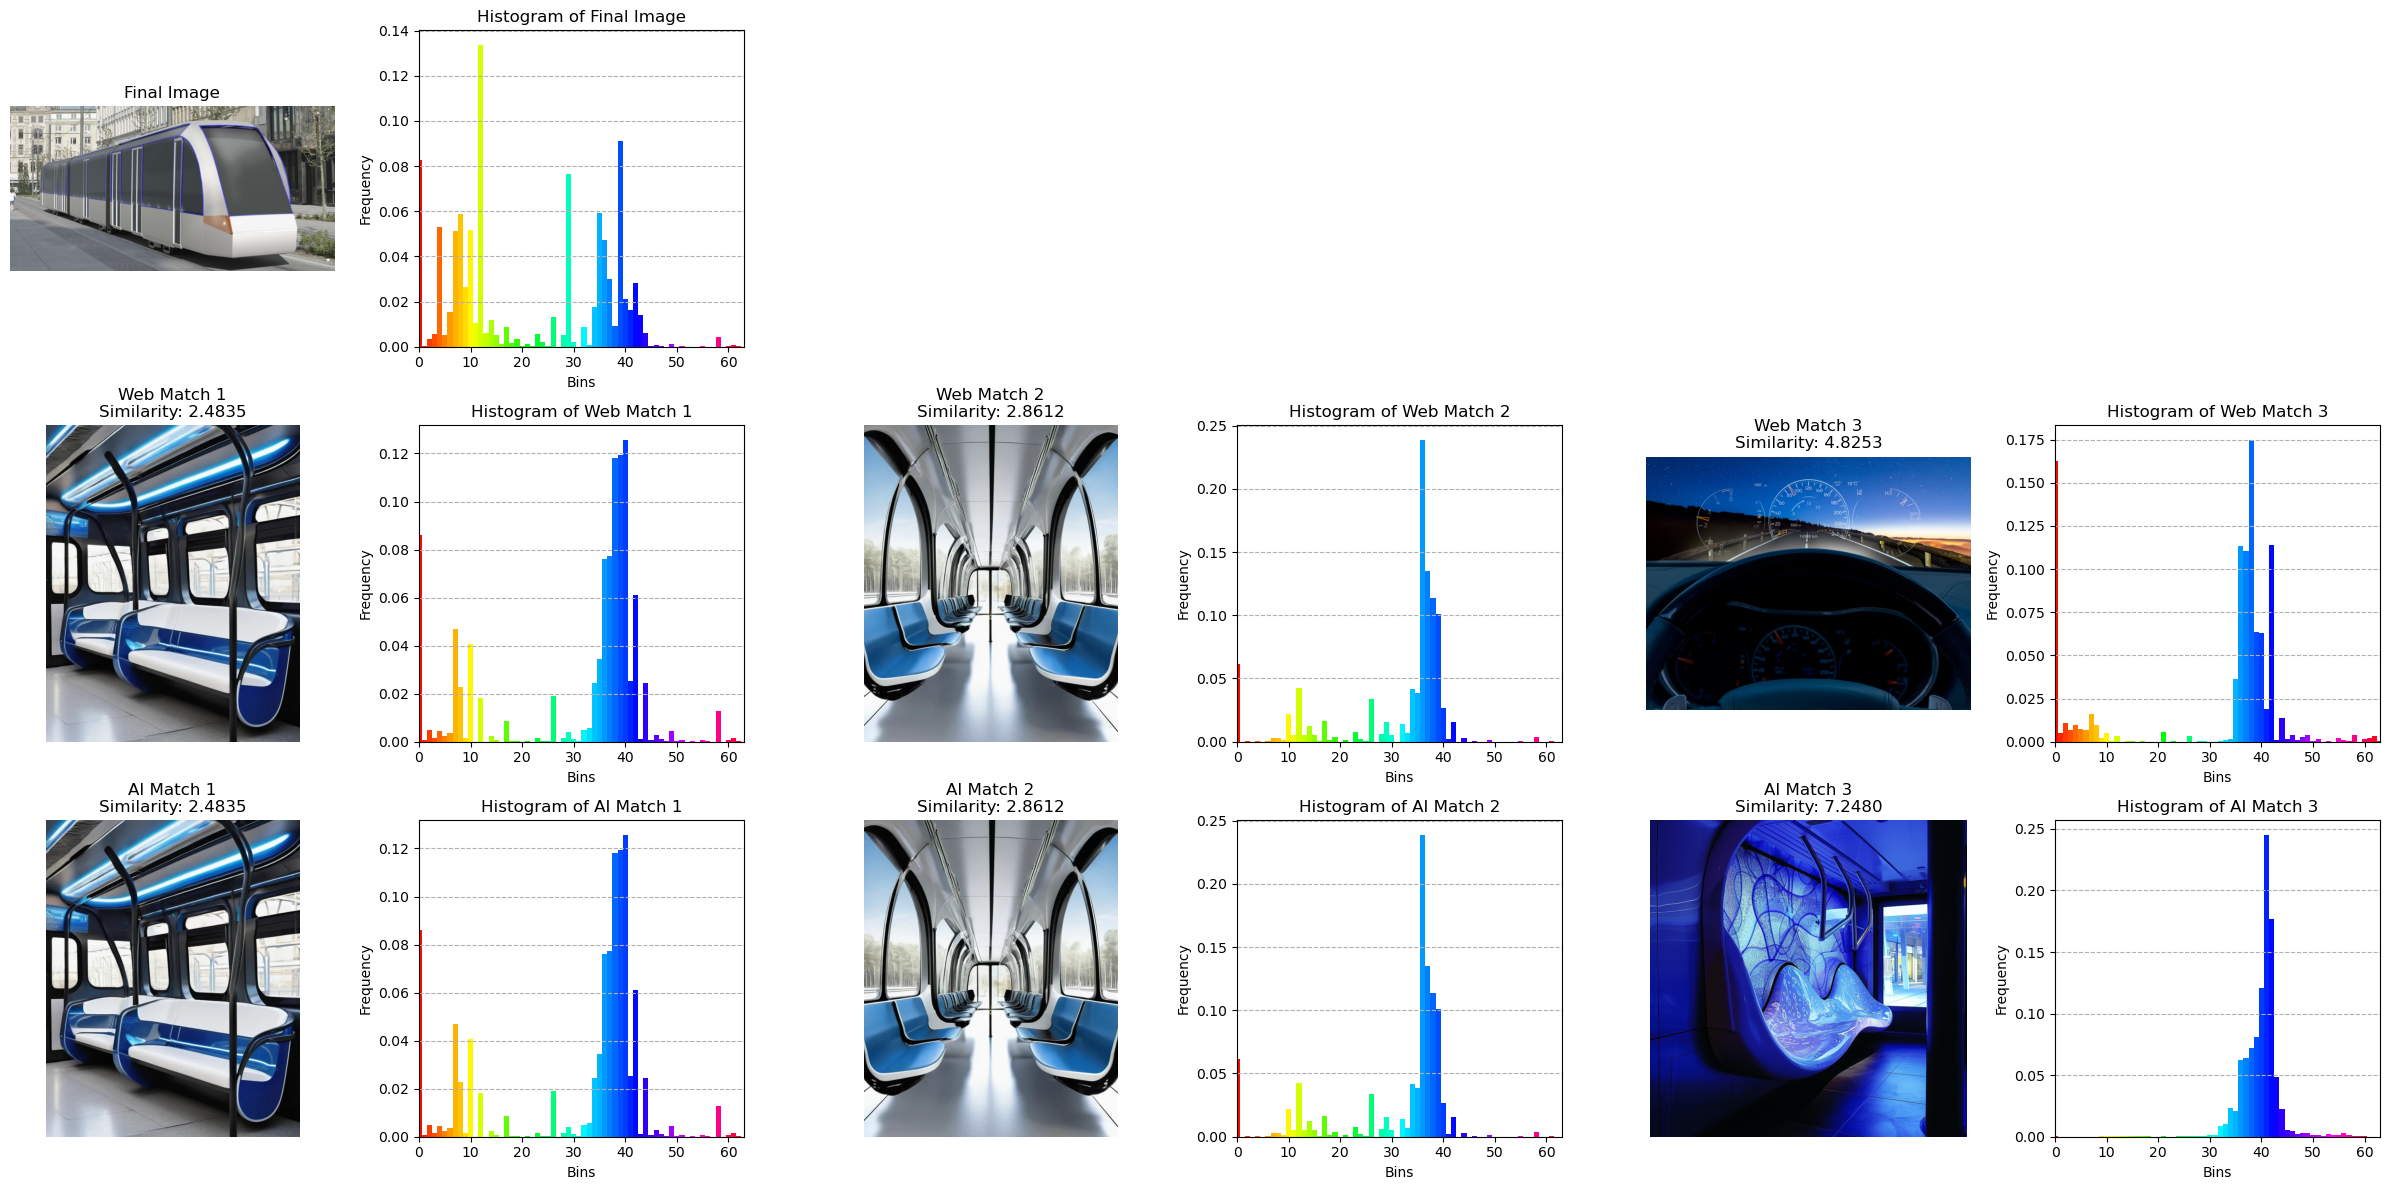

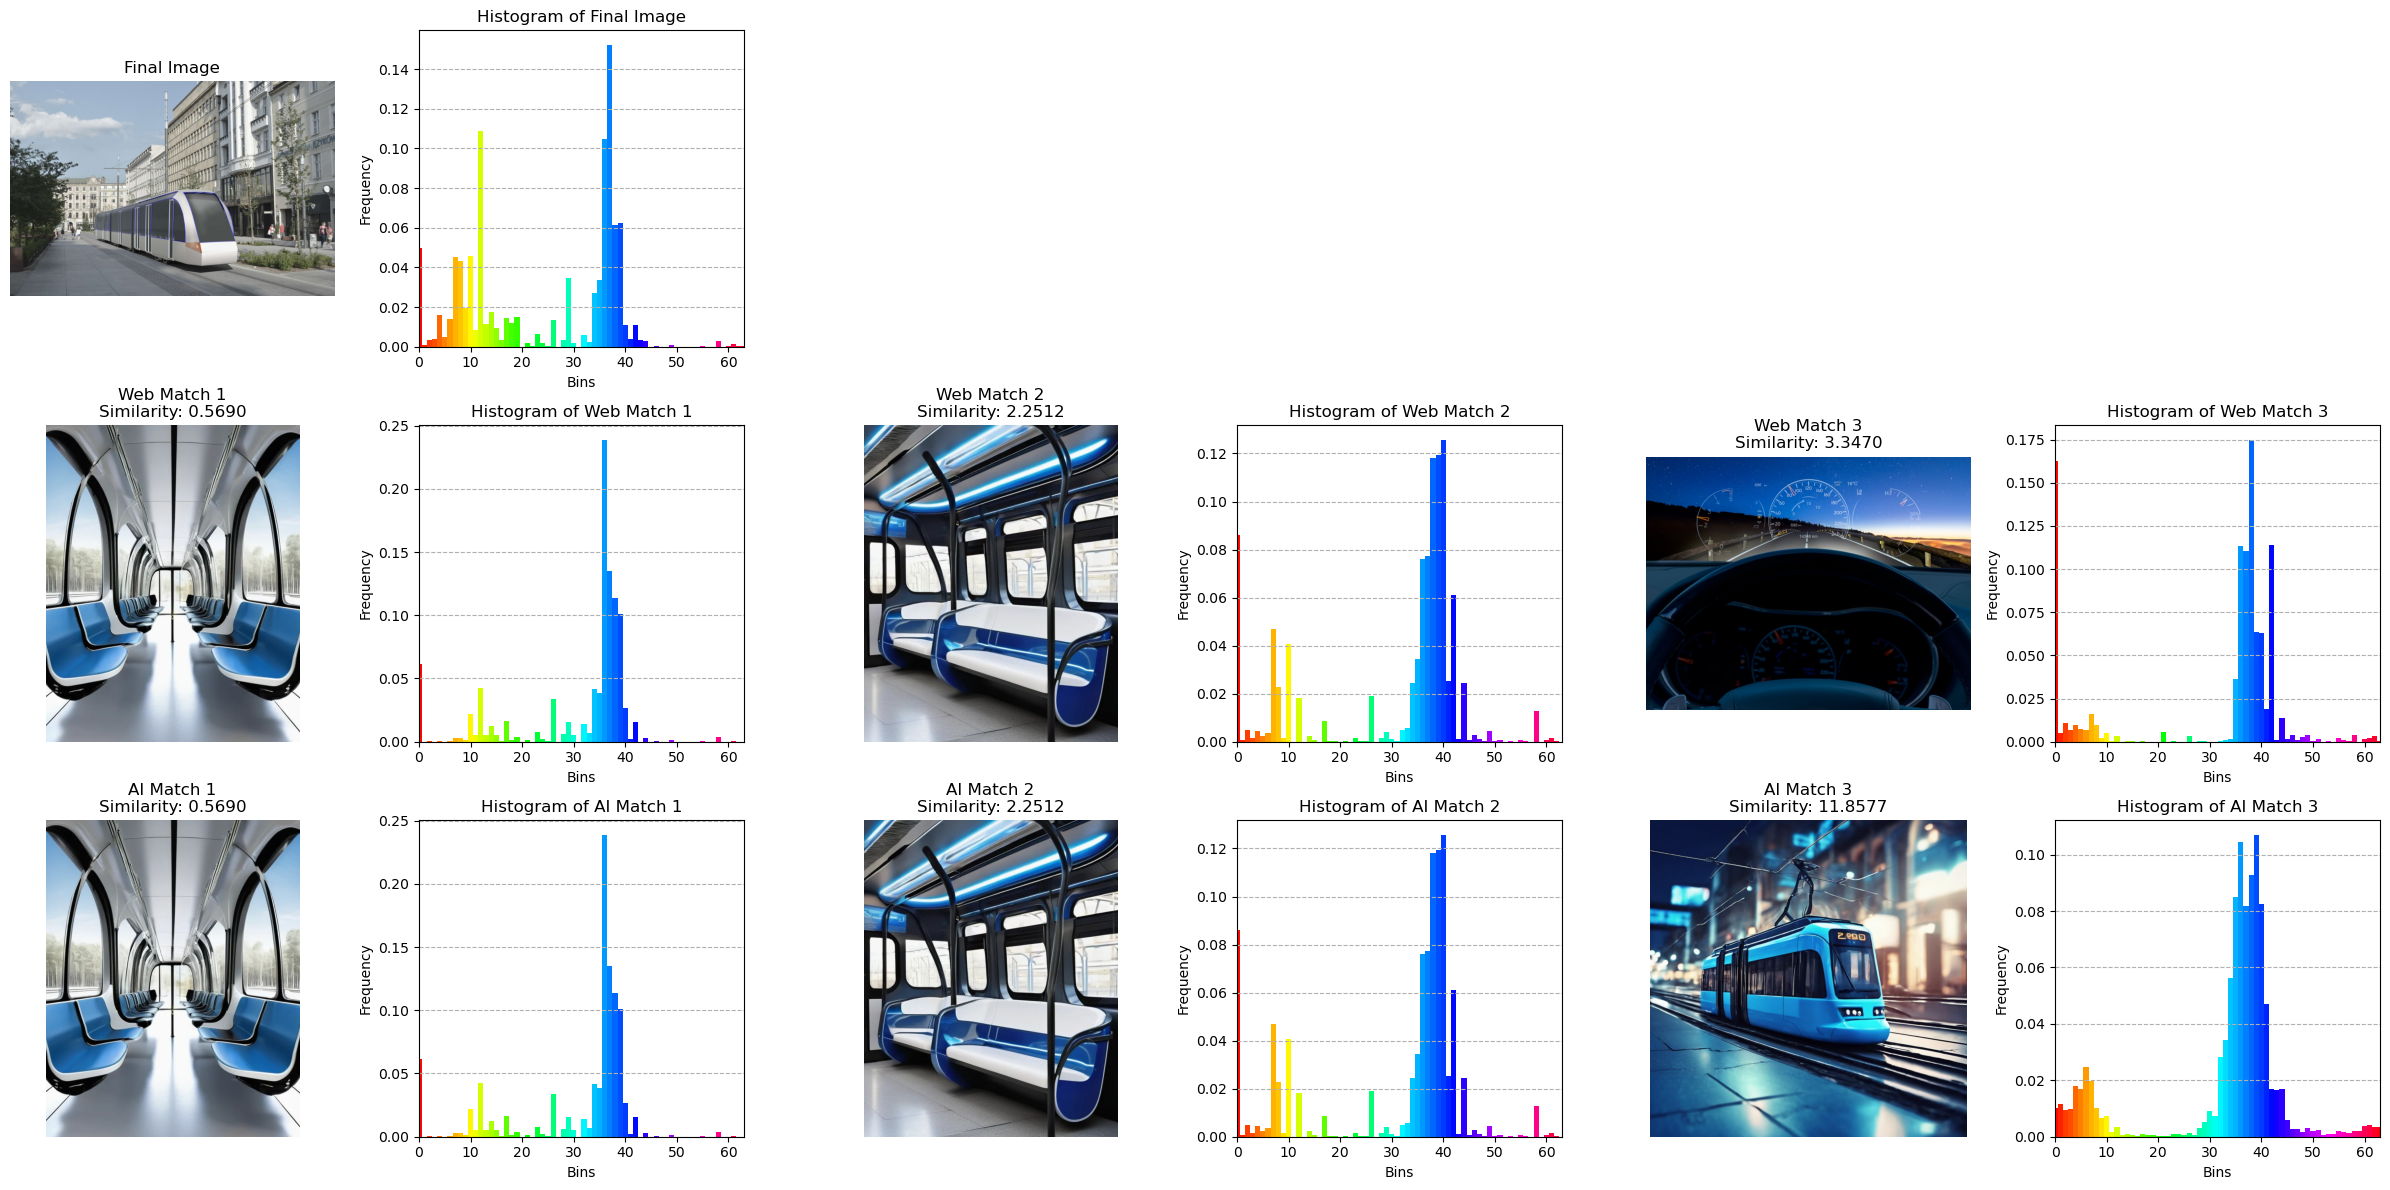

In [ ]:
compare_colors(group_id=9, bucket_size=64)